#Creating a simple neural network - MLP (Multi-Layer Perceptron)

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

In [ ]:
#import the data
data = pd.read_csv('/content/drive/MyDrive/final year/btc_tx_anomaly_detection/data/normalised_experimental_dataset.csv')

In [ ]:
y = data['out_and_tx_malicious']
X = data.drop('out_and_tx_malicious', axis=1)

# Split the data into training, validation and test sets

In [ ]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# Split into training, validation and test data
# Stratify to get even distribution of classes in the training and test data
# This is useful because we have an uneven class proprtion (far fewer fraudulent transactions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42, stratify=y)

# Create validation set as 15% of orginal dataset (not 10% of X_train which would be 10% of 80%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test)

In [ ]:
# check fraudulent transactions are distribited in the same
print(y_train.value_counts()[1] / y.value_counts()[1])
print(y_test.value_counts()[1]/ y.value_counts()[1])
print(y_val.value_counts()[1]/ y.value_counts()[1])

0.7962962962962963
0.10185185185185185
0.10185185185185185


## MLP

Start with very simple MLP:
* input layer
* 1 hidden layer
* output layer

activation functions:
- relu
- relu
- sigmoid (0-1 prediction)


In [ ]:
X_train.shape

(9060, 15)

In [ ]:
model = keras.models.Sequential()
# flatten the input
model.add(keras.layers.Dense(100, input_shape=(None, 15, ), activation="relu"))
# hidden layer
model.add(keras.layers.Dense(20, activation='relu'))
# output is either 0 or 1
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 100)         1600      
                                                                 
 dense_1 (Dense)             (None, None, 20)          2020      
                                                                 
 dense_2 (Dense)             (None, None, 1)           21        
                                                                 
Total params: 3641 (14.22 KB)
Trainable params: 3641 (14.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# compile
model.compile(loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
# now can train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_val, y_val])

Epoch 1/10
284/284 [==============================] - 6s 5ms/step - loss: 0.0390 - precision: 0.5385 - recall: 0.0814 - val_loss: 0.0355 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
284/284 [==============================] - 1s 5ms/step - loss: 0.0268 - precision: 0.8333 - recall: 0.2326 - val_loss: 0.0165 - val_precision: 1.0000 - val_recall: 0.5455
Epoch 3/10
284/284 [==============================] - 3s 12ms/step - loss: 0.0142 - precision: 0.9583 - recall: 0.5349 - val_loss: 0.0058 - val_precision: 1.0000 - val_recall: 0.7273
Epoch 4/10
284/284 [==============================] - 2s 6ms/step - loss: 0.0051 - precision: 0.9733 - recall: 0.8488 - val_loss: 0.0012 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
284/284 [==============================] - 2s 6ms/step - loss: 0.0021 - precision: 1.0000 - recall: 0.9419 - val_loss: 2.6130e-04 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 6/10
284/284 [==============================] - 1s 4ms/step - loss: 0.0

In [ ]:
history.history.keys()

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
precision_values = history_dict['precision']
recall_values = history_dict['recall']
val_loss = history_dict['val_loss']
val_precision = history_dict['val_precision']
val_recall = history_dict['val_recall']
epochs = range(1, 10 + 1)

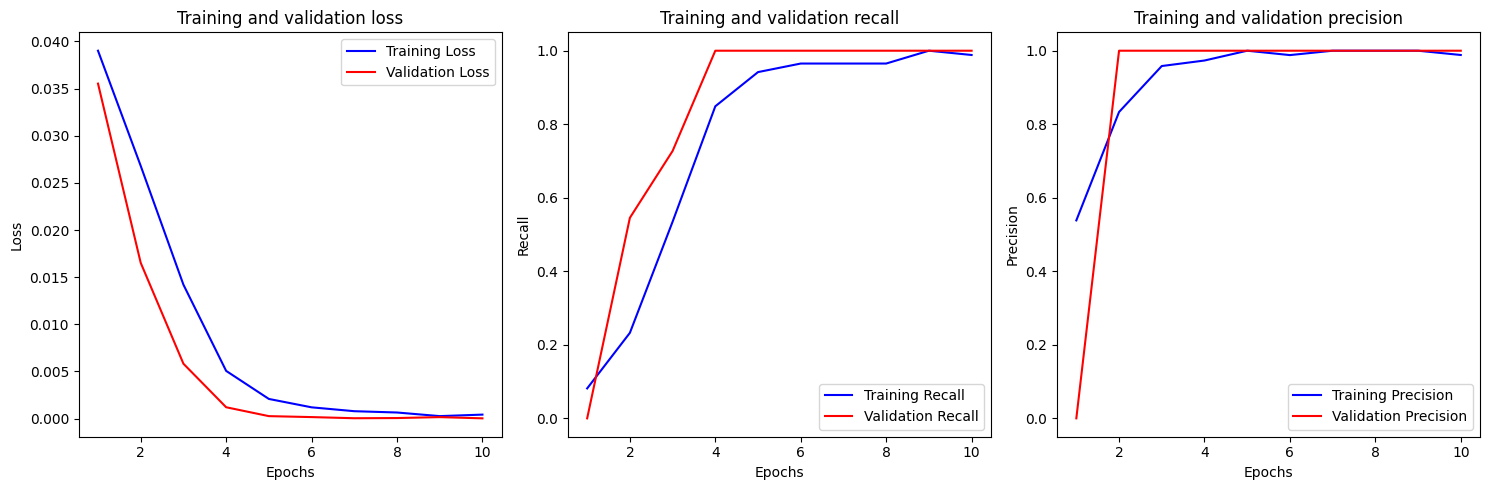

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting the first subplot (Training metric)
axes[0].plot(epochs, loss_values, 'b', label='Training Loss')
axes[0].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[0].set_title('Training and validation loss' )
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting the first subplot (Training metric)
axes[1].plot(epochs, recall_values, 'b', label='Training Recall')
axes[1].plot(epochs, val_recall, 'r', label='Validation Recall')
axes[1].set_title('Training and validation recall' )
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Recall')
axes[1].legend()

# Plotting the first subplot (Training metric)
axes[2].plot(epochs, precision_values, 'b', label='Training Precision')
axes[2].plot(epochs, val_precision, 'r', label='Validation Precision')
axes[2].set_title('Training and validation precision' )
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Precision')
axes[2].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined figure with subplots
plt.show()


In [ ]:
roc_curve = (y_test, )

In [ ]:
y_pred = model.predict(X_test)

36/36 [==============================] - 0s 2ms/step


In [ ]:
y_pred

array([[7.2782916e-07],
       [7.3624005e-07],
       [7.0748848e-07],
       ...,
       [9.0775393e-06],
       [4.8996390e-06],
       [1.8461668e-07]], dtype=float32)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

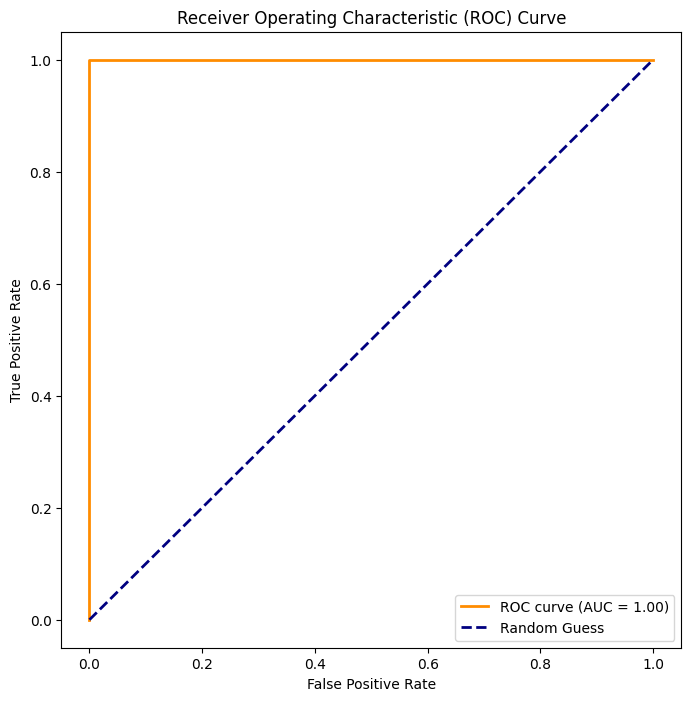

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
final_df = pd.DataFrame()
final_df["Y_original"] = y_test
threshold = 0.95
final_df["Y_predicted"] = (y_pred > threshold).astype(int)

In [ ]:
final_df[final_df['Y_original']==1]

,Y_original,Y_predicted
11064,1,1
11054,1,1
11121,1,1
11050,1,1
10843,1,1
10835,1,1
11170,1,1
10810,1,1
11116,1,1
10565,1,1


# Confusion Matrix




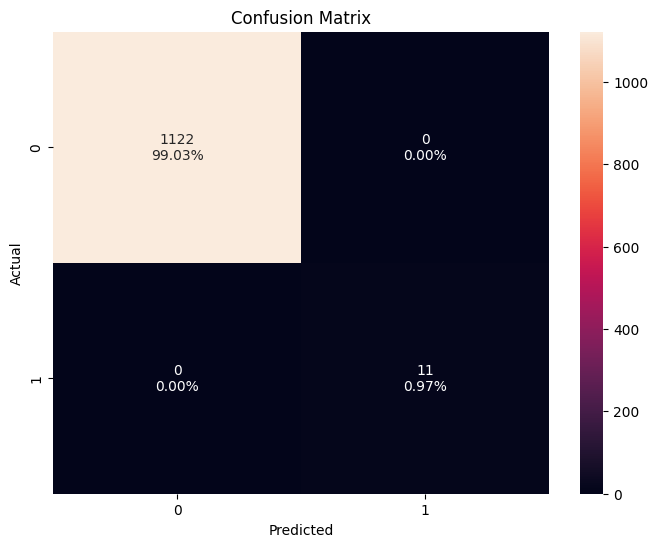

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1122
           1       1.00      1.00      1.00        11

    accuracy                           1.00      1133
   macro avg       1.00      1.00      1.00      1133
weighted avg       1.00      1.00      1.00      1133



In [ ]:
threshold = 0.95
predictions = (y_pred > threshold).astype(int)
y_true = y_test
cm = confusion_matrix(y_true, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))

group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='s')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report for additional metrics
print("Classification Report:")
print(classification_report(y_true, predictions))


# SMOTE

In [62]:
from imblearn.over_sampling import SMOTE

In [63]:
smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_val_resampled, y_val_resampled = smote.fit_resample(X_val, y_val)

In [69]:
# Count class occurrences in the resampled data
class_counts = dict(zip(*np.unique(y_train_resampled, return_counts=True)))
class_counts

{0: 8974, 1: 8974}

In [65]:
# now can train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=10, validation_data=[X_val_resampled, y_val_resampled])

Epoch 1/10
561/561 [==============================] - 2s 4ms/step - loss: 0.0029 - precision: 0.9994 - recall: 0.9996 - val_loss: 1.1400e-04 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/10
561/561 [==============================] - 2s 4ms/step - loss: 6.1735e-04 - precision: 0.9999 - recall: 0.9998 - val_loss: 2.9371e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
561/561 [==============================] - 2s 4ms/step - loss: 5.2061e-05 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.5869e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
561/561 [==============================] - 3s 5ms/step - loss: 4.2427e-05 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.5932e-06 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
561/561 [==============================] - 3s 5ms/step - loss: 1.5447e-05 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.0665e-06 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 6/10
561/561 [==============================] - 

In [70]:
y_pred_2 = model.predict(X_test)

36/36 [==============================] - 0s 3ms/step


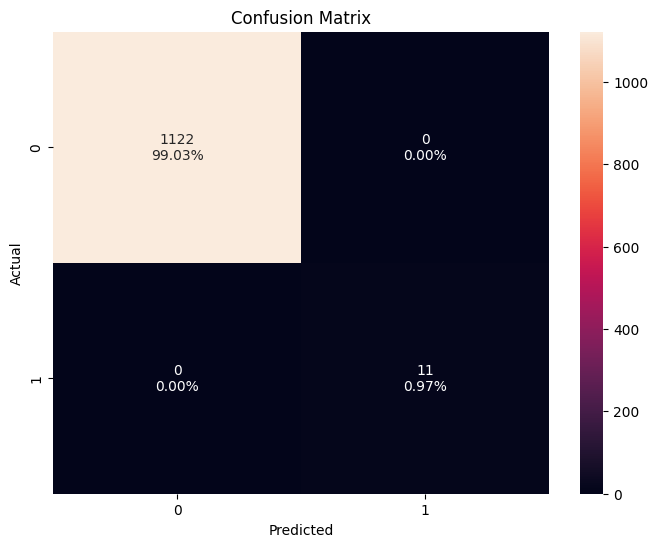

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1122
           1       1.00      1.00      1.00        11

    accuracy                           1.00      1133
   macro avg       1.00      1.00      1.00      1133
weighted avg       1.00      1.00      1.00      1133



In [71]:
threshold = 0.95
predictions = (y_pred_2 > threshold).astype(int)
y_true = y_test
cm = confusion_matrix(y_true, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))

group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='s')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report for additional metrics
print("Classification Report:")
print(classification_report(y_true, predictions))